In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00


In [4]:
import zipfile
import re
import pandas as pd
import numpy as np
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

In [5]:
df = pd.read_csv("/content/drive/MyDrive/Datathon/Datasets/treatments_2017-2020.csv")

In [6]:
substances = {-9 : "Missing/unknown/not collected/invalid",
              1 : 'None',
              2 : "Alcohol",
              3 : "Cocaine/crack",
              4 : "Marijuana/hashish",
              5 : "Heroin",
              6 : "Non-prescription methadone",
              7 : "Other opiates and synthetics",
              8 : "PCP",
              9 : "Hallucinogens",
              10 : "Methamphetamine/speed",
              11 : "Other amphetamines",
              12 : "Other stimulants",
              13 : "Benzodiazepines",
              14 : "Other tranquilizers",
              15 : "Barbiturates",
              16 : "Other sedatives or hypnotics",
              17 : "Inhalants",
              18 : "Over-the-counter medications",
              19 : "Other drugs",
              }
df[['SUB1','SUB2','SUB3']] = df[['SUB1','SUB2','SUB3']].apply(lambda x:x.apply(lambda y:substances[y]))

#Exploring facilities

In [7]:
facilities = pd.read_csv("/content/drive/MyDrive/Datathon/Datasets/treatment_facilities_2016_2020.csv",low_memory=False)

In [8]:
facilities[['STATE','state_fips']]

STATE  state_fips
0        AK         2.0
1        AK         2.0
2        AK         2.0
3        AK         2.0
4        AK         2.0
...     ...         ...
74815    ZZ         NaN
74816    ZZ         NaN
74817    ZZ         NaN
74818    ZZ         NaN
74819    ZZ         NaN

[74820 rows x 2 columns]

In [9]:
a = """
Alabama	01	AL
Alaska	02	AK
Arizona	04	AZ
Arkansas	05	AR
California	06	CA
Colorado	08	CO
Connecticut	09	CT
Delaware	10	DE
District of Columbia	11	DC
Florida	12	FL
Georgia	13	GA
Hawaii	15	HI
Idaho	16	ID
Illinois	17	IL
Indiana	18	IN
Iowa	19	IA
Kansas	20	KS
Kentucky	21	KY
Louisiana	22	LA
Maine	23	ME
Maryland	24	MD
Massachusetts	25	MA
Michigan	26	MI
Minnesota	27	MN
Mississippi	28	MS
Missouri	29	MO
Montana	30	MT
Nebraska	31	NE
Nevada	32	NV
New Hampshire	33	NH
New Jersey	34	NJ
New Mexico	35	NM
New York	36	NY
North Carolina	37	NC
North Dakota	38	ND
Ohio	39	OH
Oklahoma	40	OK
Oregon	41	OR
Pennsylvania	42	PA
Rhode Island	44	RI
South Carolina	45	SC
South Dakota	46	SD
Tennessee	47	TN
Texas	48	TX
Utah	49	UT
Vermont	50	VT
Virginia	51	VA
Washington	53	WA
West Virginia	54	WV
Wisconsin	55	WI
Wyoming	56	WY
American Samoa	60	AS	
Federated States of Micronesia	64	FM	
Guam	66	GU	
Marshall Islands	68	MH	
Commonwealth of the Northern Mariana Islands	69	MP	
Palau	70	PW	
Puerto Rico	72	PR	
U.S. Minor Outlying Islands	74	UM	
U.S. Virgin Islands	78	VI	
Baker Island	81 LO
Howland Island	84 La
Jarvis Island	86 SS
Johnston Atoll	67 LO
Kingman Reef	89 KK
Midway Islands	71 LO
Navassa Island	76 AS
Palmyra Atoll	95 AS
Wake Island	79 ds
"""
map = {}
f_map = {}
for ind,i in enumerate(a.split('\n')):
    if ind==0:
      continue
    _ = i.split()
    try:
      code,state = int(_[-2]),' '.join(_[0:-2])
      short = _[-1]
    except Exception as e:
      print(e,_)
    map[code]=state
    f_map[short]=state
for i in facilities['STATE'].unique():
  if i not in f_map.keys():
    f_map[i]="None"
facilities.STATE = facilities['STATE'].apply(lambda x:f_map[x])

list index out of range []


In [10]:
map
df.STFIPS = df.STFIPS.apply(lambda x:map[x])

In [11]:
facilities.drop('state_fips',inplace = True ,axis =1)

In [12]:
facilities.drop(facilities[facilities.TREATMT==0].index,inplace = True)

In [13]:
state_groups = df.groupby('STFIPS')
kentucky = state_groups.get_group('Kentucky')
north_carolina = state_groups.get_group('North Carolina')
Colorado = state_groups.get_group('Colorado')


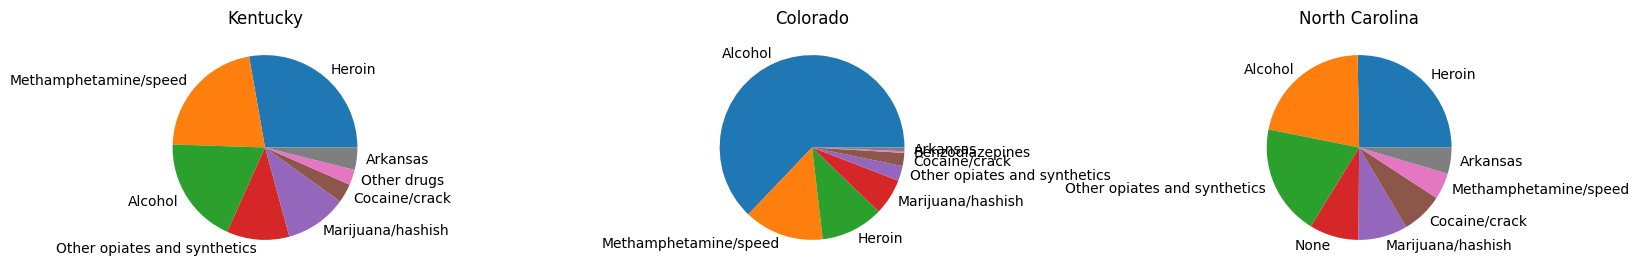

In [144]:
fig,subplots = plt.subplots(1,3,figsize=(20,3))

for index , state in enumerate(['Kentucky','Colorado','North Carolina']):
    counts = state_groups.get_group(state).SUB1.value_counts().sort_values(ascending=False)
    summ = sum(counts[7:])
    counts = counts[:7]
    counts['Arkansas'] = summ
    subplots[index].pie(counts,labels = counts.keys())
    subplots[index].set_title(state)
plt.show()


In [14]:

reason={1:'Treatment_completionrate',
        2:'Dropped out of treatment',
        3:'Terminated by facility',
        4:'Transfered to other facility',
        5:'incarerated',
        6:'Death',
        7:'Other',
        8:'Total'}
Colorado = Colorado.copy()
Colorado.REASON = Colorado.REASON.apply(lambda x:reason[x])

<Axes: xlabel='SUB1'>

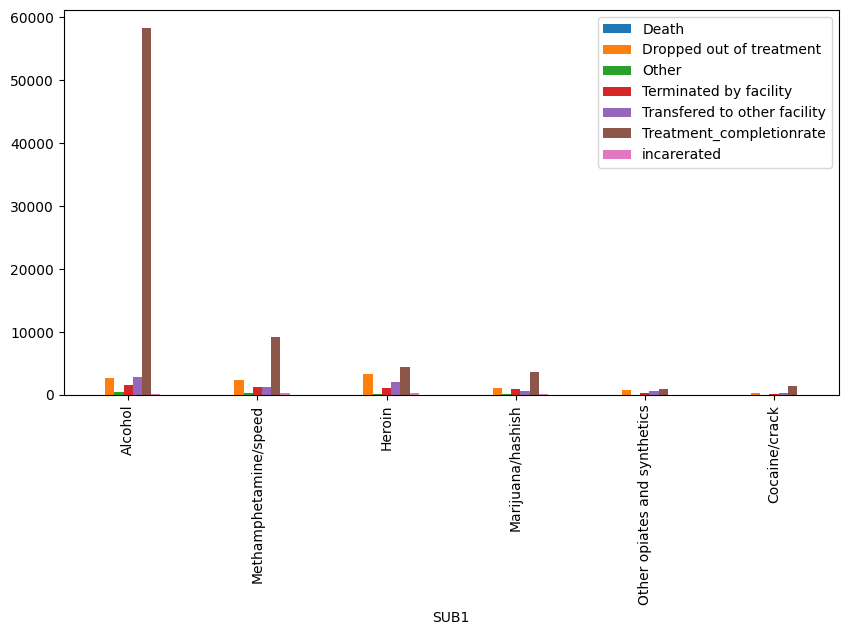

In [146]:
substance_wise_Colorado = Colorado.groupby('SUB1').apply(lambda x:pd.DataFrame(x['REASON'].value_counts()).T).reset_index().drop('level_1',axis=1).set_index('SUB1').fillna(0)
substance_wise_Colorado = substance_wise_Colorado.loc[substance_wise_Colorado.sum(axis=1).sort_values(ascending=False).index]
substance_wise_Colorado = substance_wise_Colorado.sort_index(axis=1)
substance_wise_Colorado.iloc[:6].plot.bar(figsize=(10,5),width=.5)

In [147]:
substance_wise_Colorado.loc['Alcohol',"Treatment_completionrate"]/substance_wise_Colorado.sum(axis=1)['Alcohol']

0.8823181639026165

In [148]:
kentucky = kentucky.copy()
kentucky.REASON = kentucky.REASON.apply(lambda x:reason[x])

<Axes: xlabel='SUB1'>

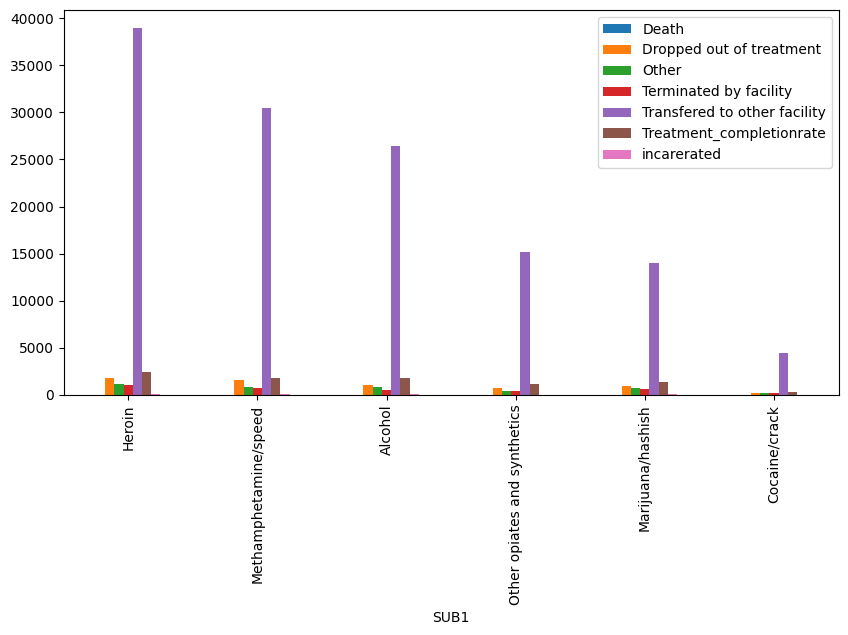

In [149]:
substance_wise_kentucky = kentucky.groupby('SUB1').apply(lambda x:pd.DataFrame(x['REASON'].value_counts()).T).reset_index().drop('level_1',axis=1).set_index('SUB1').fillna(0)
substance_wise_kentucky = substance_wise_kentucky.loc[substance_wise_kentucky.sum(axis=1).sort_values(ascending=False).index]
substance_wise_kentucky = substance_wise_kentucky.sort_index(axis=1)
substance_wise_kentucky.iloc[:6].plot.bar(figsize=(10,5))

# in order to find which programs of kentucky fecilities effecting Over bad performance we can compare its facilities to Colorado  

# But Colorado has more Alcohol cases but has 88% completion rate
# So we can pick out facilities out of Kentucky and Colorado who provide better facilities for alcohol as we can see both SRVC108 and SRVC71 are focused on Alcohol so picking up those facilities who offer these two programs and then comparing them 

In [8]:
groups = facilities.groupby(['STATE'])

In [9]:

kentucky = groups.get_group('Kentucky').copy()
Colorado = groups.get_group('Colorado').copy()

In [10]:
columnts_todrop = ['TREATMT','CASEID','STATE','SRVC85','SRVC86','SRVC87','OTP',"OPIOIDMAINT","OPIOIDWDRAW","OPIOIDDETOX",'OPIOIDNAL']

In [11]:

regexp  = re.compile('^LANG')

for i in kentucky.columns:
    if regexp.search(i):
        columnts_todrop.append(i)
kentucky.drop(columnts_todrop,axis =1,inplace = True)
Colorado.drop(columnts_todrop,axis =1,inplace = True)

In [12]:
kentucky.SRVC108 = kentucky.SRVC108.apply(lambda x : int(x))
Colorado.SRVC108 = Colorado.SRVC108.apply(lambda x : int(x))
kentucky.SRVC71 = kentucky.SRVC71.apply(lambda x : int(x))
Colorado.SRVC71 = Colorado.SRVC71.apply(lambda x : int(x))
Colorado.drop(Colorado[Colorado['SRVC108']==0].index,inplace = True )
kentucky.drop(kentucky[kentucky['SRVC108']==0].index,inplace = True )
Colorado.drop(Colorado[Colorado['SRVC71']==0].index,inplace = True )
kentucky.drop(kentucky[kentucky['SRVC71']==0].index,inplace = True )

In [13]:
kentucky.shape

(408, 58)

In [14]:
kentucky['Target'] = 1
Colorado['Target'] = 0
Data  = pd.concat([kentucky,Colorado])
Data

DETOX  OWNERSHP  FEDOWN HOSPITAL LOCS  ASSESSMENT  TESTING  TRANSITION  \
5495       1         1     NaN        0  NaN         7.0      2.0         2.0   
5513       0         2     NaN        0  NaN         5.0      0.0         0.0   
5530       1         1     NaN        0  NaN         4.0      7.0         2.0   
5532       0         1     NaN        0  NaN         5.0      1.0         2.0   
5541       1         2     NaN        1    1         6.0      7.0         2.0   
...      ...       ...     ...      ...  ...         ...      ...         ...   
61749      0         2     NaN        0  NaN         7.0      2.0         4.0   
61750      0         2     NaN        0  NaN         7.0      1.0         2.0   
61753      0         2     NaN        0  NaN         7.0      4.0         3.0   
61754      0         2     NaN        0  NaN         7.0      4.0         3.0   
61755      1         1     NaN        0  NaN         8.0      3.0         4.0   

       ANCILLARY  OTHER_SRVC  ... REVCHK5  REVCHK10  REVCHK15 REVCHK2  \
5495        15.0         2.0  ...       1         1         1       1   
5513         6.0         0.0  ...       1         1         1       1   
5530        12.0         1.0  ...       0         0         0       0   
5532        10.0         0.0  ...       0         0         0       0   
5541        11.0         3.0  ...       1         1         D       1   
...          ...         ...  ...     ...       ...       ...     ...   
61749        3.0         3.0  ...       1         1         1       1   
61750        5.0         0.0  ...       1         0         1       1   
61753        5.0         1.0  ...       1         1         1       1   
61754        5.0         1.0  ...       1         1         1       1   
61755        3.0         3.0  ...       0         1         0       1   

      REVCHK17 LOC5 LICEN ACCRED  year Target  
5495         1    0     1      0  2016      1  
5513         0    0     1      1  2016      1  
5530         0    0     1      1  2016      1  
5532         0    0     1      0  2016      1  
5541         D    0     1      M  2016      1  
...        ...  ...   ...    ...   ...    ...  
61749        0    0     1      0  2020      0  
61750        0    0     1      0  2020      0  
61753        0    0     1      0  2020      0  
61754        0    0     1      0  2020      0  
61755        0    0     1      0  2020      0  

[846 rows x 59 columns]

In [15]:
values = Data.isna().sum()
display(values)
columns_to_drop=[]
for i in kentucky.columns:
    if values[i]>90:
        columns_to_drop.append(i)

DETOX           0
OWNERSHP        0
FEDOWN        811
HOSPITAL        0
LOCS          744
ASSESSMENT      0
TESTING         0
TRANSITION      0
ANCILLARY       0
OTHER_SRVC      0
SRVC75          0
SRVC71          0
SRVC108         0
COMPSAT       459
DUI_DWI         0
ONLYDUI       566
SIGNLANG        0
SRVC30          0
SRVC34          0
SRVC33          0
SRVC64          0
SRVC63          0
SRVC62          0
SRVC113         0
SRVC114         0
SRVC115         0
SRVC61          0
SRVC31          0
SRVC32          0
SRVC116         0
CTYPE4          0
CTYPEHI1      762
CTYPEHI2      762
CTYPE7          0
CTYPERC1      640
CTYPERC3      640
CTYPERC4      640
CTYPE1          0
CTYPE6         95
CTYPEML        95
CTYPEOP        95
CTYPE2         95
CTYPE3         95
FEESCALE        4
PAYASST         4
EARMARK         0
REVCHK3         0
REVCHK1         0
REVCHK8         0
REVCHK5         0
REVCHK10        0
REVCHK15        0
REVCHK2         0
REVCHK17        0
LOC5            0
LICEN     

In [16]:
Data.drop(columns_to_drop,axis =1,inplace=True)

In [17]:
Data.dtypes

DETOX           int64
OWNERSHP        int64
HOSPITAL       object
ASSESSMENT    float64
TESTING       float64
TRANSITION    float64
ANCILLARY     float64
OTHER_SRVC    float64
SRVC75         object
SRVC71          int64
SRVC108         int64
DUI_DWI        object
SIGNLANG       object
SRVC30         object
SRVC34         object
SRVC33         object
SRVC64         object
SRVC63         object
SRVC62         object
SRVC113        object
SRVC114        object
SRVC115        object
SRVC61         object
SRVC31         object
SRVC32         object
SRVC116        object
CTYPE4          int64
CTYPE7          int64
CTYPE1          int64
FEESCALE       object
PAYASST        object
EARMARK        object
REVCHK3        object
REVCHK1        object
REVCHK8        object
REVCHK5        object
REVCHK10       object
REVCHK15       object
REVCHK2        object
REVCHK17       object
LOC5           object
LICEN          object
ACCRED         object
year            int64
Target          int64
dtype: obj

In [18]:
Data.drop('ACCRED', axis=1, inplace = True)

In [19]:

frequent_values = Data.replace('M', np.nan).apply(lambda x: x.value_counts().idxmax())

Data = Data.replace('M', frequent_values)

In [24]:
frequent_values = Data.replace('D', np.nan).apply(lambda x: x.value_counts().idxmax())

Data = Data.replace('D', frequent_values)

In [45]:

frequent_values = Data.replace('V', np.nan).apply(lambda x: x.value_counts().idxmax())

Data = Data.replace('V', frequent_values)

In [20]:
Data.TESTING = Data.TESTING.apply(lambda x:int(float(x)))
Data.TRANSITION = Data.TRANSITION.apply(lambda x:int(float(x)))
Data.ANCILLARY = Data.ANCILLARY.apply(lambda x:int(float(x)))

In [29]:
cat_data= []
for i in Data.columns:
    counts = Data[i].value_counts()
    if len(counts)>2:
        cat_data.append(i)

In [30]:
cat_data

['OWNERSHP',
 'ASSESSMENT',
 'TESTING',
 'TRANSITION',
 'ANCILLARY',
 'OTHER_SRVC',
 'LICEN',
 'year']

In [38]:
Data['ANCILLARY'] = Data['ANCILLARY'].apply(lambda x:int(float(x)))

In [39]:
cat_data.pop(4)

'ANCILLARY'

In [33]:
Data.fillna(0,inplace=True)

In [34]:
for column in Data.columns:
    if column not in cat_data:
        Data[column] = Data[column].apply(lambda x:int(float(x)))

In [43]:
for column in cat_data:
    Data[column] = Data[column].apply(lambda x:str(x))

In [46]:

model = CatBoostClassifier(verbose=False, task_type='GPU', devices='0')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data[Data.columns[:-1]], Data.Target, test_size=0.15, random_state=42)
pool = Pool(data=X_train, label=y_train,cat_features=cat_data)
model.fit(X_train,y_train)


In [50]:
y_pred = model.predict(X_test)
f1_score(y_pred,y_test,average='macro')

0.9448682170542635

<Axes: >

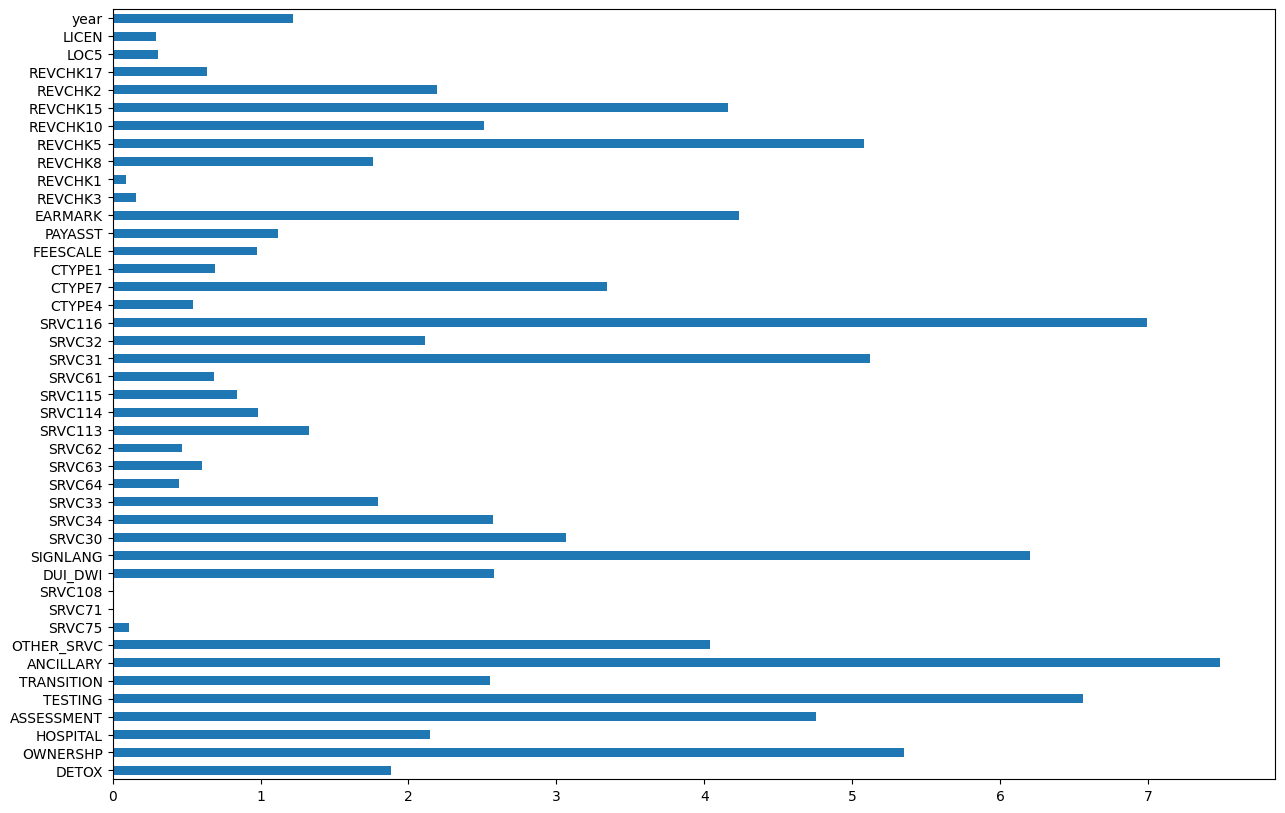

In [56]:
map = {}
for importance in zip(X_train.columns,model.get_feature_importance()):
    map[importance[0]] = importance[1]
pd.Series(map).plot.barh(figsize=(15,10))

Top 3 features 

1.   ANCILLARY
2.   SRVC116
3.   TESTING


  SRVC116


In [57]:
Data.drop(['ANCILLARY','TESTING','SRVC116','SIGNLANG'],axis=1,inplace=True)

In [59]:
for i in ['ANCILLARY','TESTING','SRVC116','SIGNLANG']:
    if i in cat_data:
        cat_data.pop(cat_data.index(i))

0.9212549603174602


<Axes: >

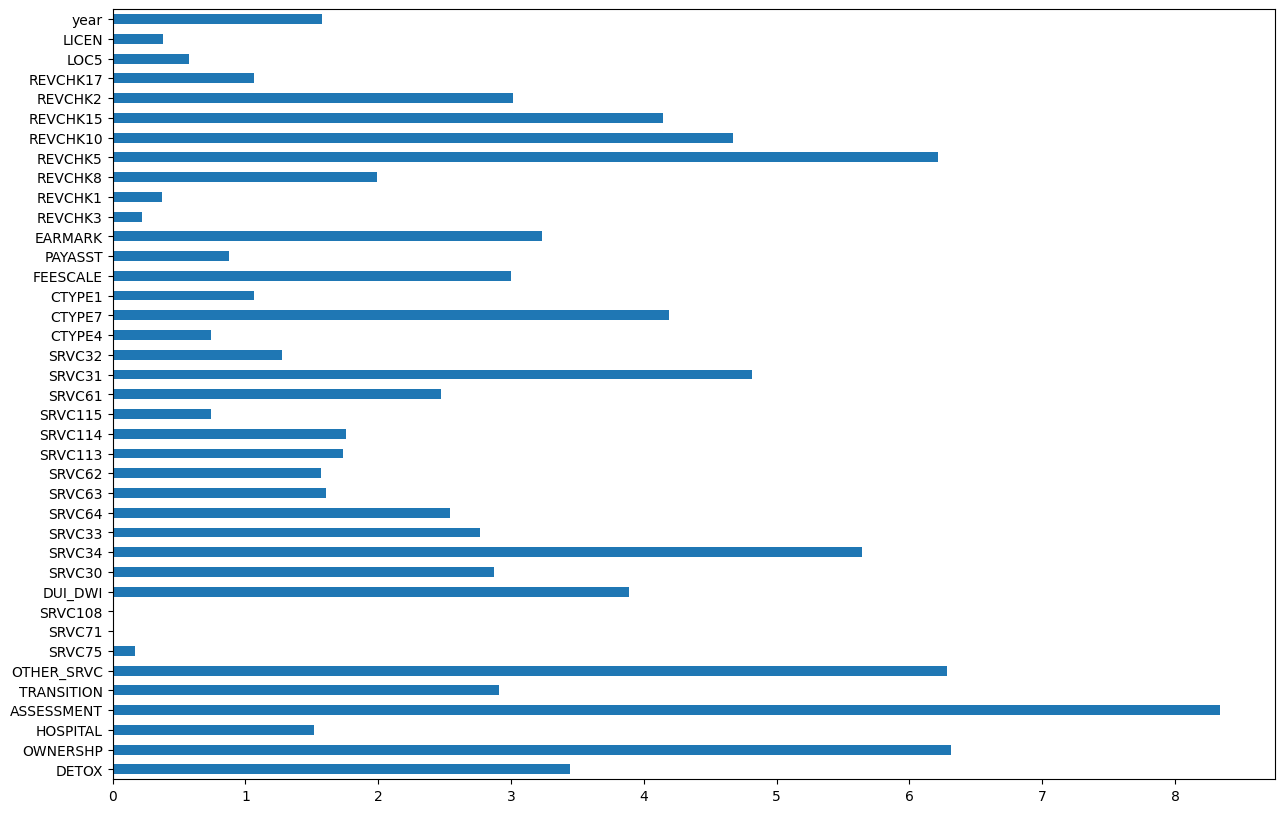

In [62]:

model = CatBoostClassifier(verbose=False, task_type='GPU', devices='0')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data[Data.columns[:-1]], Data.Target, test_size=0.15, random_state=42)
pool = Pool(data=X_train, label=y_train,cat_features=cat_data)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f1_score(y_pred,y_test,average='macro'))
map = {}
for importance in zip(X_train.columns,model.get_feature_importance()):
    map[importance[0]] = importance[1]
pd.Series(map).plot.barh(figsize=(15,10))

#f1score dropped a little but we still have features to drop

0.9133643410852714


<Axes: >

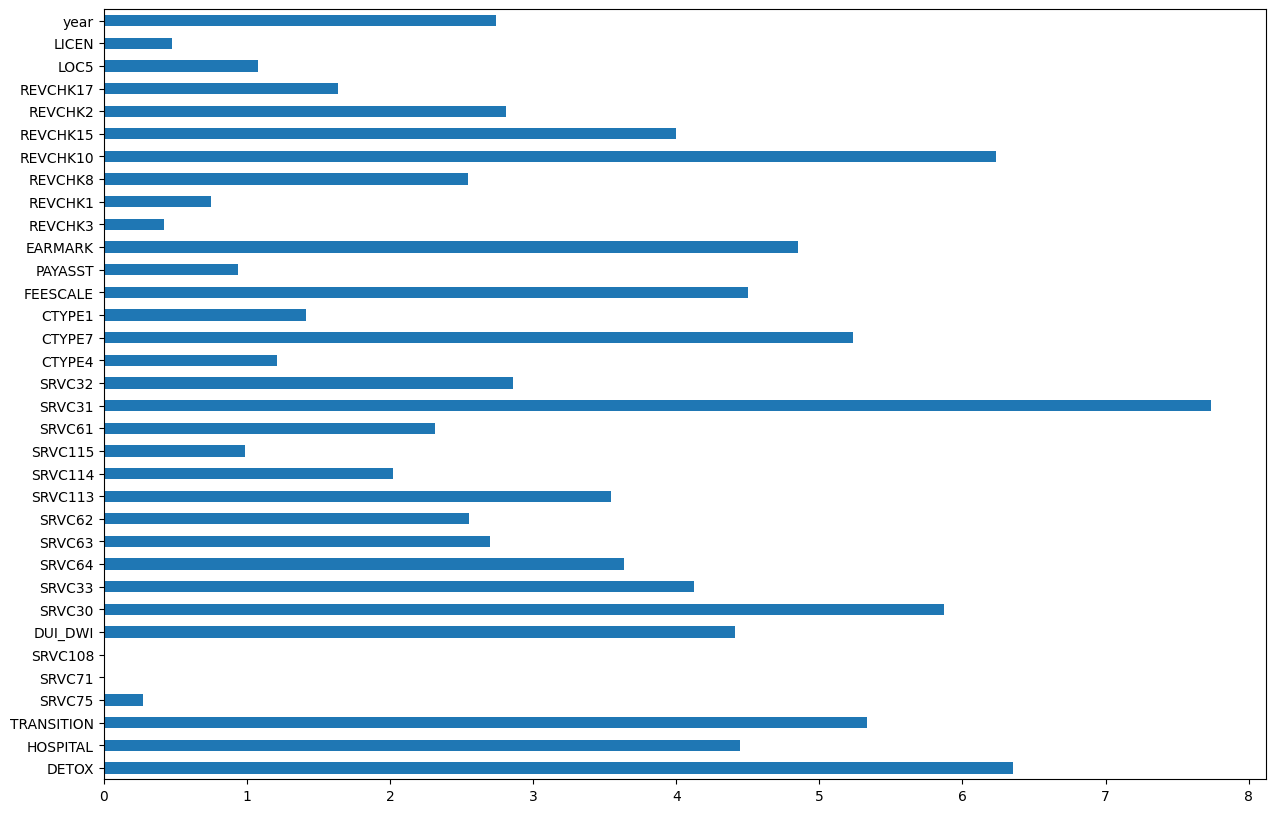

In [63]:
features_to_drop = ["ASSESSMENT",'OTHER_SRVC','REVCHK5','SRVC34','OWNERSHP']
Data.drop(features_to_drop,axis=1,inplace=True)
for i in features_to_drop:
    if i in cat_data:
        cat_data.pop(cat_data.index(i))

model = CatBoostClassifier(verbose=False, task_type='GPU', devices='0')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data[Data.columns[:-1]], Data.Target, test_size=0.15, random_state=42)
pool = Pool(data=X_train, label=y_train,cat_features=cat_data)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f1_score(y_pred,y_test,average='macro'))
map = {}
for importance in zip(X_train.columns,model.get_feature_importance()):
    map[importance[0]] = importance[1]
pd.Series(map).plot.barh(figsize=(15,10))

# next most important features seperating two facilities 
    1  SRVC31
    2  REVCHK10
    3  DETOX
    4  SRVC30

0.8266749379652606


<Axes: >

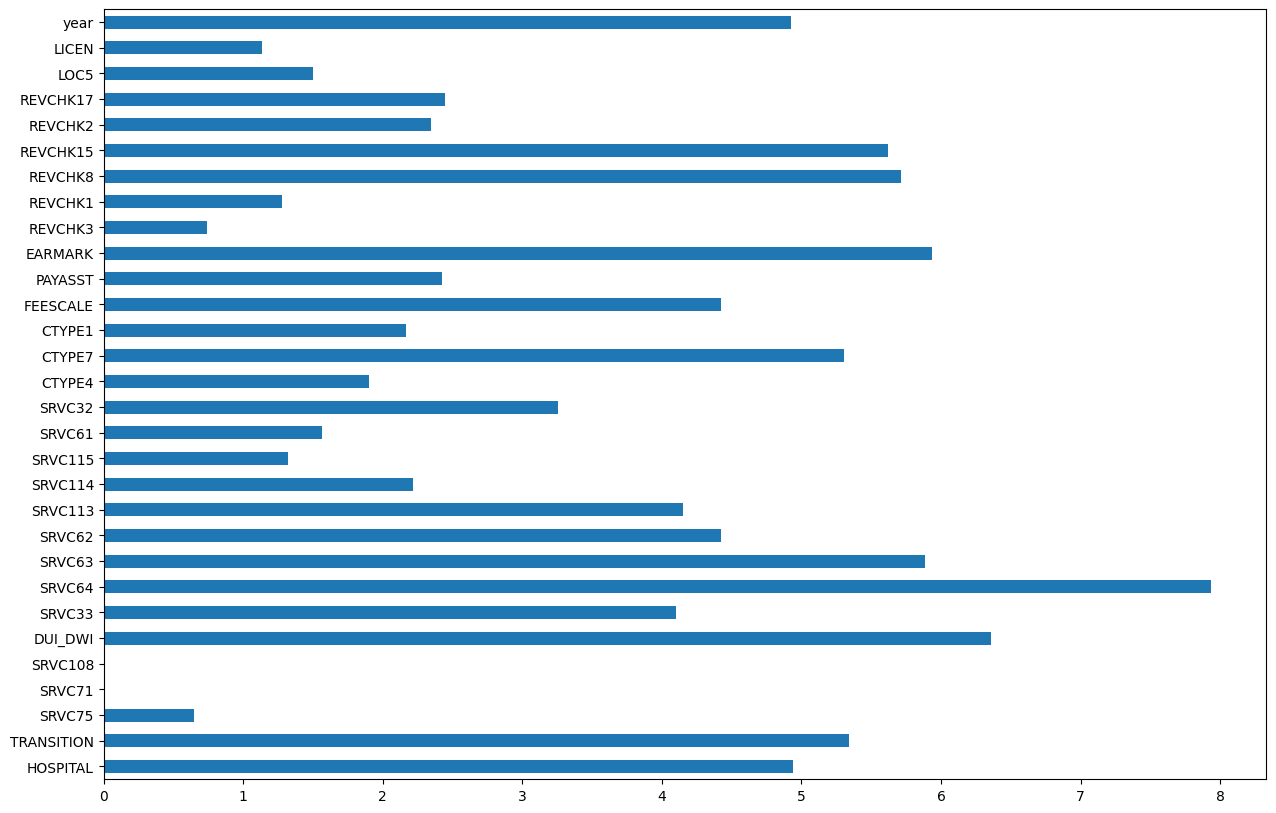

In [64]:
features_to_drop = ["SRVC31",'REVCHK10','DETOX','SRVC30']
Data.drop(features_to_drop,axis=1,inplace=True)
for i in features_to_drop:
    if i in cat_data:
        cat_data.pop(cat_data.index(i))

model = CatBoostClassifier(verbose=False, task_type='GPU', devices='0')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data[Data.columns[:-1]], Data.Target, test_size=0.15, random_state=42)
pool = Pool(data=X_train, label=y_train,cat_features=cat_data)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(f1_score(y_pred,y_test,average='macro'))
map = {}
for importance in zip(X_train.columns,model.get_feature_importance()):
    map[importance[0]] = importance[1]
pd.Series(map).plot.barh(figsize=(15,10))

#Stopping the process because score dropped sudden to 82%
    SRVC64 seperating

In [65]:
important_features = ['ANCILLARY','TESTING','SRVC116','SIGNLANG']+["ASSESSMENT",'OTHER_SRVC','REVCHK5','SRVC34','OWNERSHP']+["SRVC31",'REVCHK10','DETOX','SRVC30']

# In those important features as we can see few are just normal programs like
    1 ANCILLARY - No of ancillary services
    2 Testing - No of testing services
    3 SIGNLANG - sign language 
    4 ASSESSMENT - no of he number of assessments and pre-treatment services offered by this facility
    5 OTHER_SRVC - no of other services 
    6 OWNERSHP - facility owned by whom


#Observations  over Ownership


    in Colorado   
        

*   265 private non- profit
*   124 private profirt
*   others owned by state and fed govt 
    out of 431 faclities



    in kentucky
*   202 private profit oriented
*   196 private non -profit
    out of 400 facilities that provide alcohol abuse treatment services


         


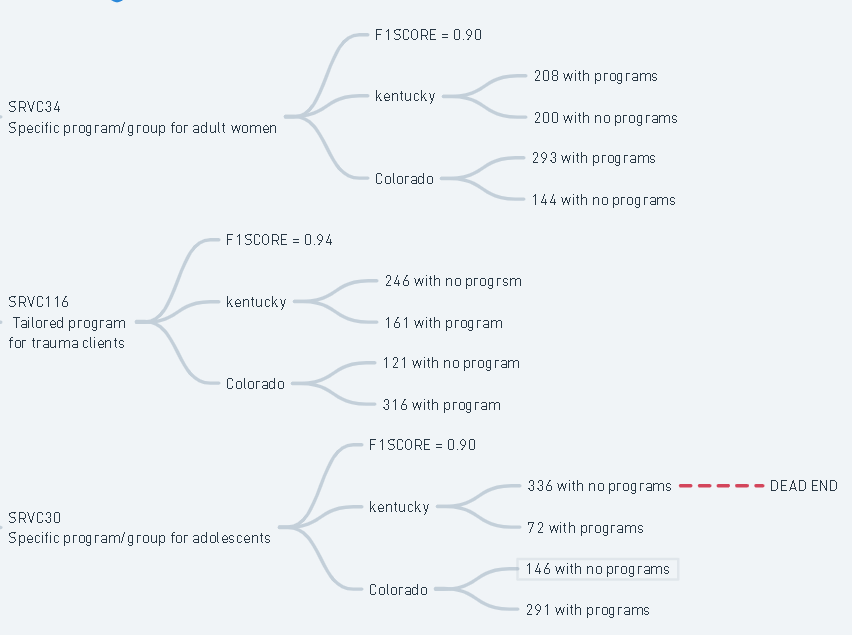

# Editing Dataframe 

In [68]:
a = """
Alabama	01	AL
Alaska	02	AK
Arizona	04	AZ
Arkansas	05	AR
California	06	CA
Colorado	08	CO
Connecticut	09	CT
Delaware	10	DE
District of Columbia	11	DC
Florida	12	FL
Georgia	13	GA
Hawaii	15	HI
Idaho	16	ID
Illinois	17	IL
Indiana	18	IN
Iowa	19	IA
Kansas	20	KS
Kentucky	21	KY
Louisiana	22	LA
Maine	23	ME
Maryland	24	MD
Massachusetts	25	MA
Michigan	26	MI
Minnesota	27	MN
Mississippi	28	MS
Missouri	29	MO
Montana	30	MT
Nebraska	31	NE
Nevada	32	NV
New Hampshire	33	NH
New Jersey	34	NJ
New Mexico	35	NM
New York	36	NY
North Carolina	37	NC
North Dakota	38	ND
Ohio	39	OH
Oklahoma	40	OK
Oregon	41	OR
Pennsylvania	42	PA
Rhode Island	44	RI
South Carolina	45	SC
South Dakota	46	SD
Tennessee	47	TN
Texas	48	TX
Utah	49	UT
Vermont	50	VT
Virginia	51	VA
Washington	53	WA
West Virginia	54	WV
Wisconsin	55	WI
Wyoming	56	WY
American Samoa	60	AS	
Federated States of Micronesia	64	FM	
Guam	66	GU	
Marshall Islands	68	MH	
Commonwealth of the Northern Mariana Islands	69	MP	
Palau	70	PW	
Puerto Rico	72	PR	
U.S. Minor Outlying Islands	74	UM	
U.S. Virgin Islands	78	VI	
Baker Island	81 LO
Howland Island	84 La
Jarvis Island	86 SS
Johnston Atoll	67 LO
Kingman Reef	89 KK
Midway Islands	71 LO
Navassa Island	76 AS
Palmyra Atoll	95 AS
Wake Island	79 ds
"""
map = {}
for ind,i in enumerate(a.split('\n')):
    if ind==0:
      continue
    _ = i.split()
    try:
      code,state = int(_[-2]),' '.join(_[0:-2])
    except Exception as e:
      print(e,_)
    map[code]=state
df.STFIPS = df.STFIPS.apply(lambda x:map[x])
f_map = {}
for ind,i in enumerate(a.split('\n')):
    if ind==0:
      continue
    _ = i.split()
    try:
      code,state = _[-1],' '.join(_[0:-2])
    except Exception as e:
      print(e,_)
    f_map[code]=state
for i in facilities.STATE.unique():
  if i not in f_map.keys():
    f_map[i] = 'No information'
facilities.STATE = facilities.STATE.apply(lambda x:f_map[x])

list index out of range []
list index out of range []


# Checking each other features

#SRVC34 which is Special programs for adult women






In [75]:
groups = df.groupby(["STFIPS",'SUB1'])
kentucky_alc = groups.get_group(('Kentucky','Alcohol'))

In [19]:
Gender ={1:'Male',2:"Female",-9:'Unkonw'}
df.GENDER = df.GENDER.apply(lambda x:Gender[x])

Text(0.5, 1.0, 'Overall Drugs')

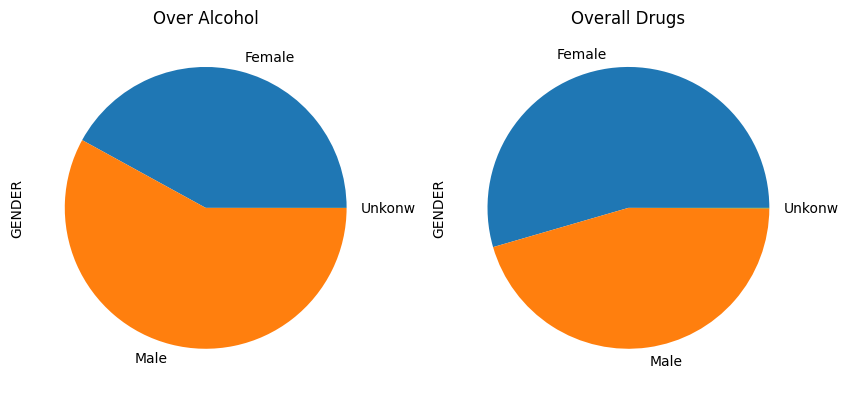

In [78]:
fig,subplots = plt.subplots(1,2,figsize=(10,5))
kentucky_alc.GENDER.value_counts().sort_index().plot.pie(ax=subplots[0])
subplots[0].set_title("Over Alcohol")
df[df['STFIPS']=='Kentucky'].GENDER.value_counts().sort_index().plot.pie(ax=subplots[1])
subplots[1].set_title("Overall Drugs")

kentucky has more Male substance abusers in case of Alcohol While overall drugs cases Females are more

Text(0.5, 1.0, 'Overall Drugs')

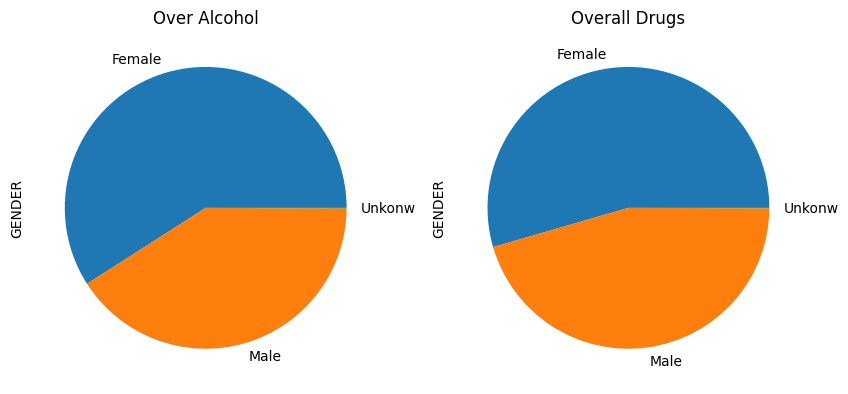

In [79]:
kentucky_her = groups.get_group(('Kentucky','Heroin'))
fig,subplots = plt.subplots(1,2,figsize=(10,5))
kentucky_her.GENDER.value_counts().sort_index().plot.pie(ax=subplots[0])
subplots[0].set_title("Over Alcohol")
df[df['STFIPS']=='Kentucky'].GENDER.value_counts().sort_index().plot.pie(ax=subplots[1])
subplots[1].set_title("Overall Drugs")

# Kentucky has more female Heroin users than male 

---



Digging more into age of female abusers of Heroin

<Axes: >

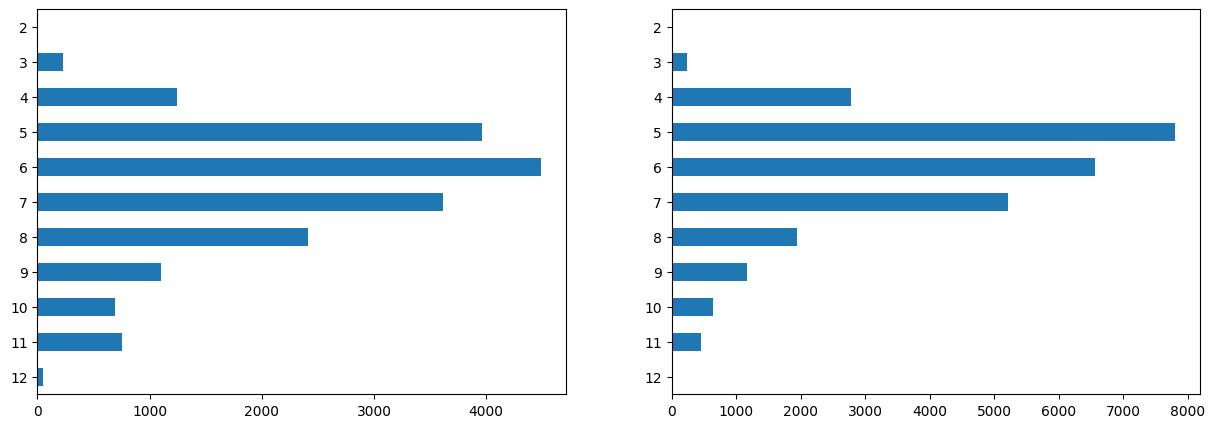

In [127]:
fig,subplots = plt.subplots(1,2,figsize=(15,5))
kentucky_her[kentucky_her.GENDER=='Male'].AGE.value_counts().sort_index(ascending=False).iloc[:-1].plot.barh(ax=subplots[0])
kentucky_her[kentucky_her.GENDER=='Female'].AGE.value_counts().sort_index(ascending=False).plot.barh(ax=subplots[1])

# 90% heroin cases in Women is for adult women
    Age group of 25-29 women consume Heroin more than men

In [121]:
SRVC34 = {'0':"No program",'1':"adult women specific programs",'M':'Missing'}
facilities.SRVC34 = facilities.SRVC34.apply(lambda x:SRVC34[x])

<Axes: ylabel='SRVC34'>

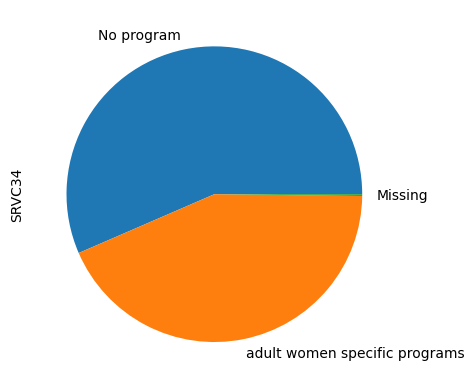

In [133]:
facilities[facilities.STATE=='Kentucky'].SRVC34.value_counts().plot.pie()

Adult women specific programs are very few when we have more Heroin cases in adult women

#SRVC30 which is Special programs for adolescents

Text(0.5, 1.0, 'Overall Drugs')

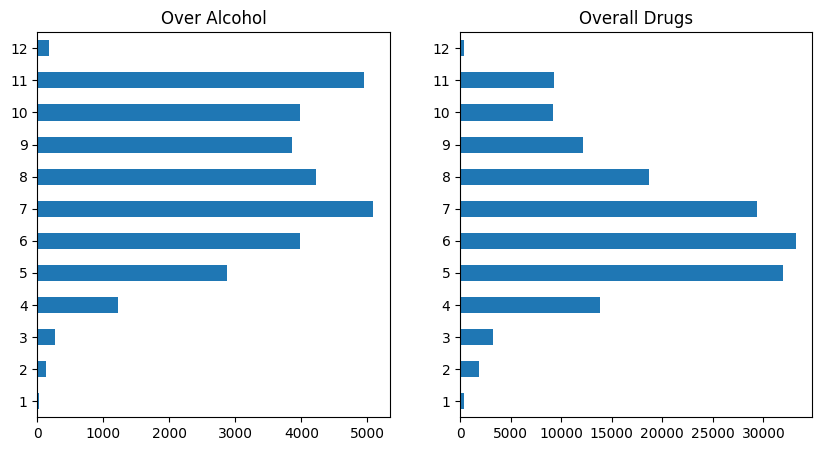

In [141]:
fig,subplots = plt.subplots(1,2,figsize=(10,5))
kentucky_alc.AGE.value_counts().sort_index().plot.barh(ax=subplots[0])
subplots[0].set_title("Over Alcohol")
df[df['STFIPS']=='Kentucky'].AGE.value_counts().sort_index().plot.barh(ax=subplots[1])
subplots[1].set_title("Overall Drugs")

Text(0.5, 1.0, 'Overall Drugs')

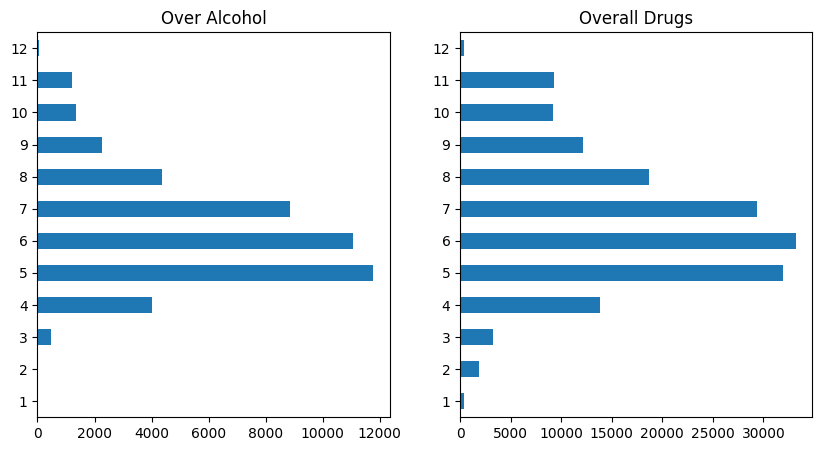

In [142]:
fig,subplots = plt.subplots(1,2,figsize=(10,5))
kentucky_her.AGE.value_counts().sort_index().plot.barh(ax=subplots[0])
subplots[0].set_title("Over Alcohol")
df[df['STFIPS']=='Kentucky'].AGE.value_counts().sort_index().plot.barh(ax=subplots[1])
subplots[1].set_title("Overall Drugs")

# as there are very small percentage of adolascents using drugs in kentucky then its not needed

#Exploring next feature that seperated two facilities better 
#SRVC31 which is Special programs for patients co occuring substance abuse disorder

In [15]:
psyc = {1:"Co-occuring MD",2:"No disorder",-9:'Missing'}
df['PSYPROB'] = df['PSYPROB'].apply(lambda x:psyc[x])

<Axes: ylabel='PSYPROB'>

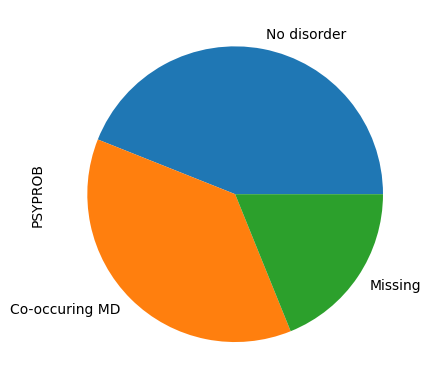

In [16]:
df[df['SUB1']=='Alcohol']['PSYPROB'].value_counts().plot.pie()

In [24]:
kentucky = df[df['STFIPS']=='Kentucky']

<Axes: ylabel='PSYPROB'>

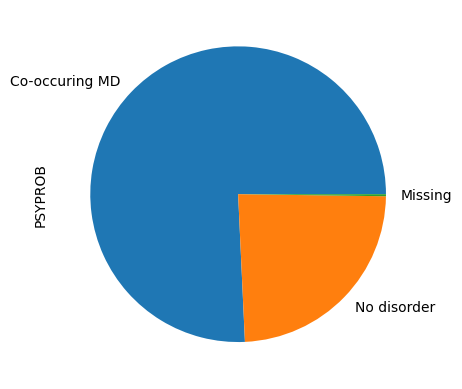

In [25]:
kentucky.PSYPROB.value_counts().plot.pie()

#Kentucky has more Co-occuring Substance abuse MD cases

Text(0.5, 1.0, 'Male')

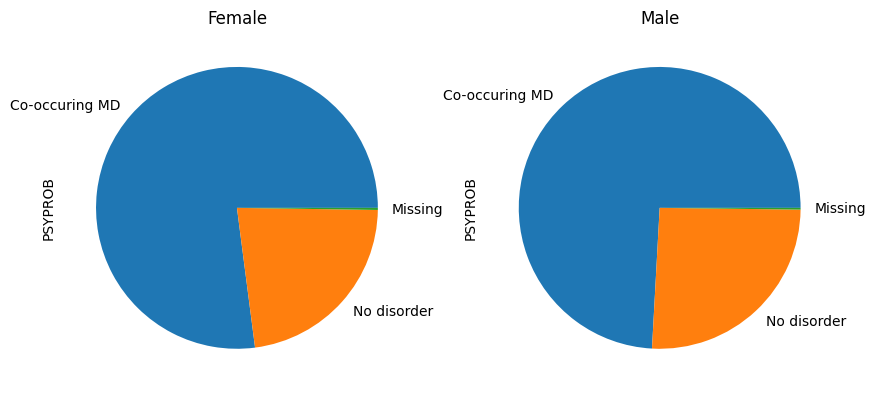

In [33]:
fig,subplots = plt.subplots(1,2,figsize=(10,5))
kentucky_women = kentucky[kentucky.GENDER=='Female']
kentucky_men = kentucky[kentucky.GENDER=='Male']
kentucky_women.PSYPROB.value_counts().plot.pie(ax=subplots[0])
subplots[0].set_title('Female')
kentucky_men.PSYPROB.value_counts().plot.pie(ax=subplots[1])
subplots[1].set_title('Male')

#Exploring Co-occuring substance abuse MD patients more

#trying to findout where these cases reside and which substance they reside

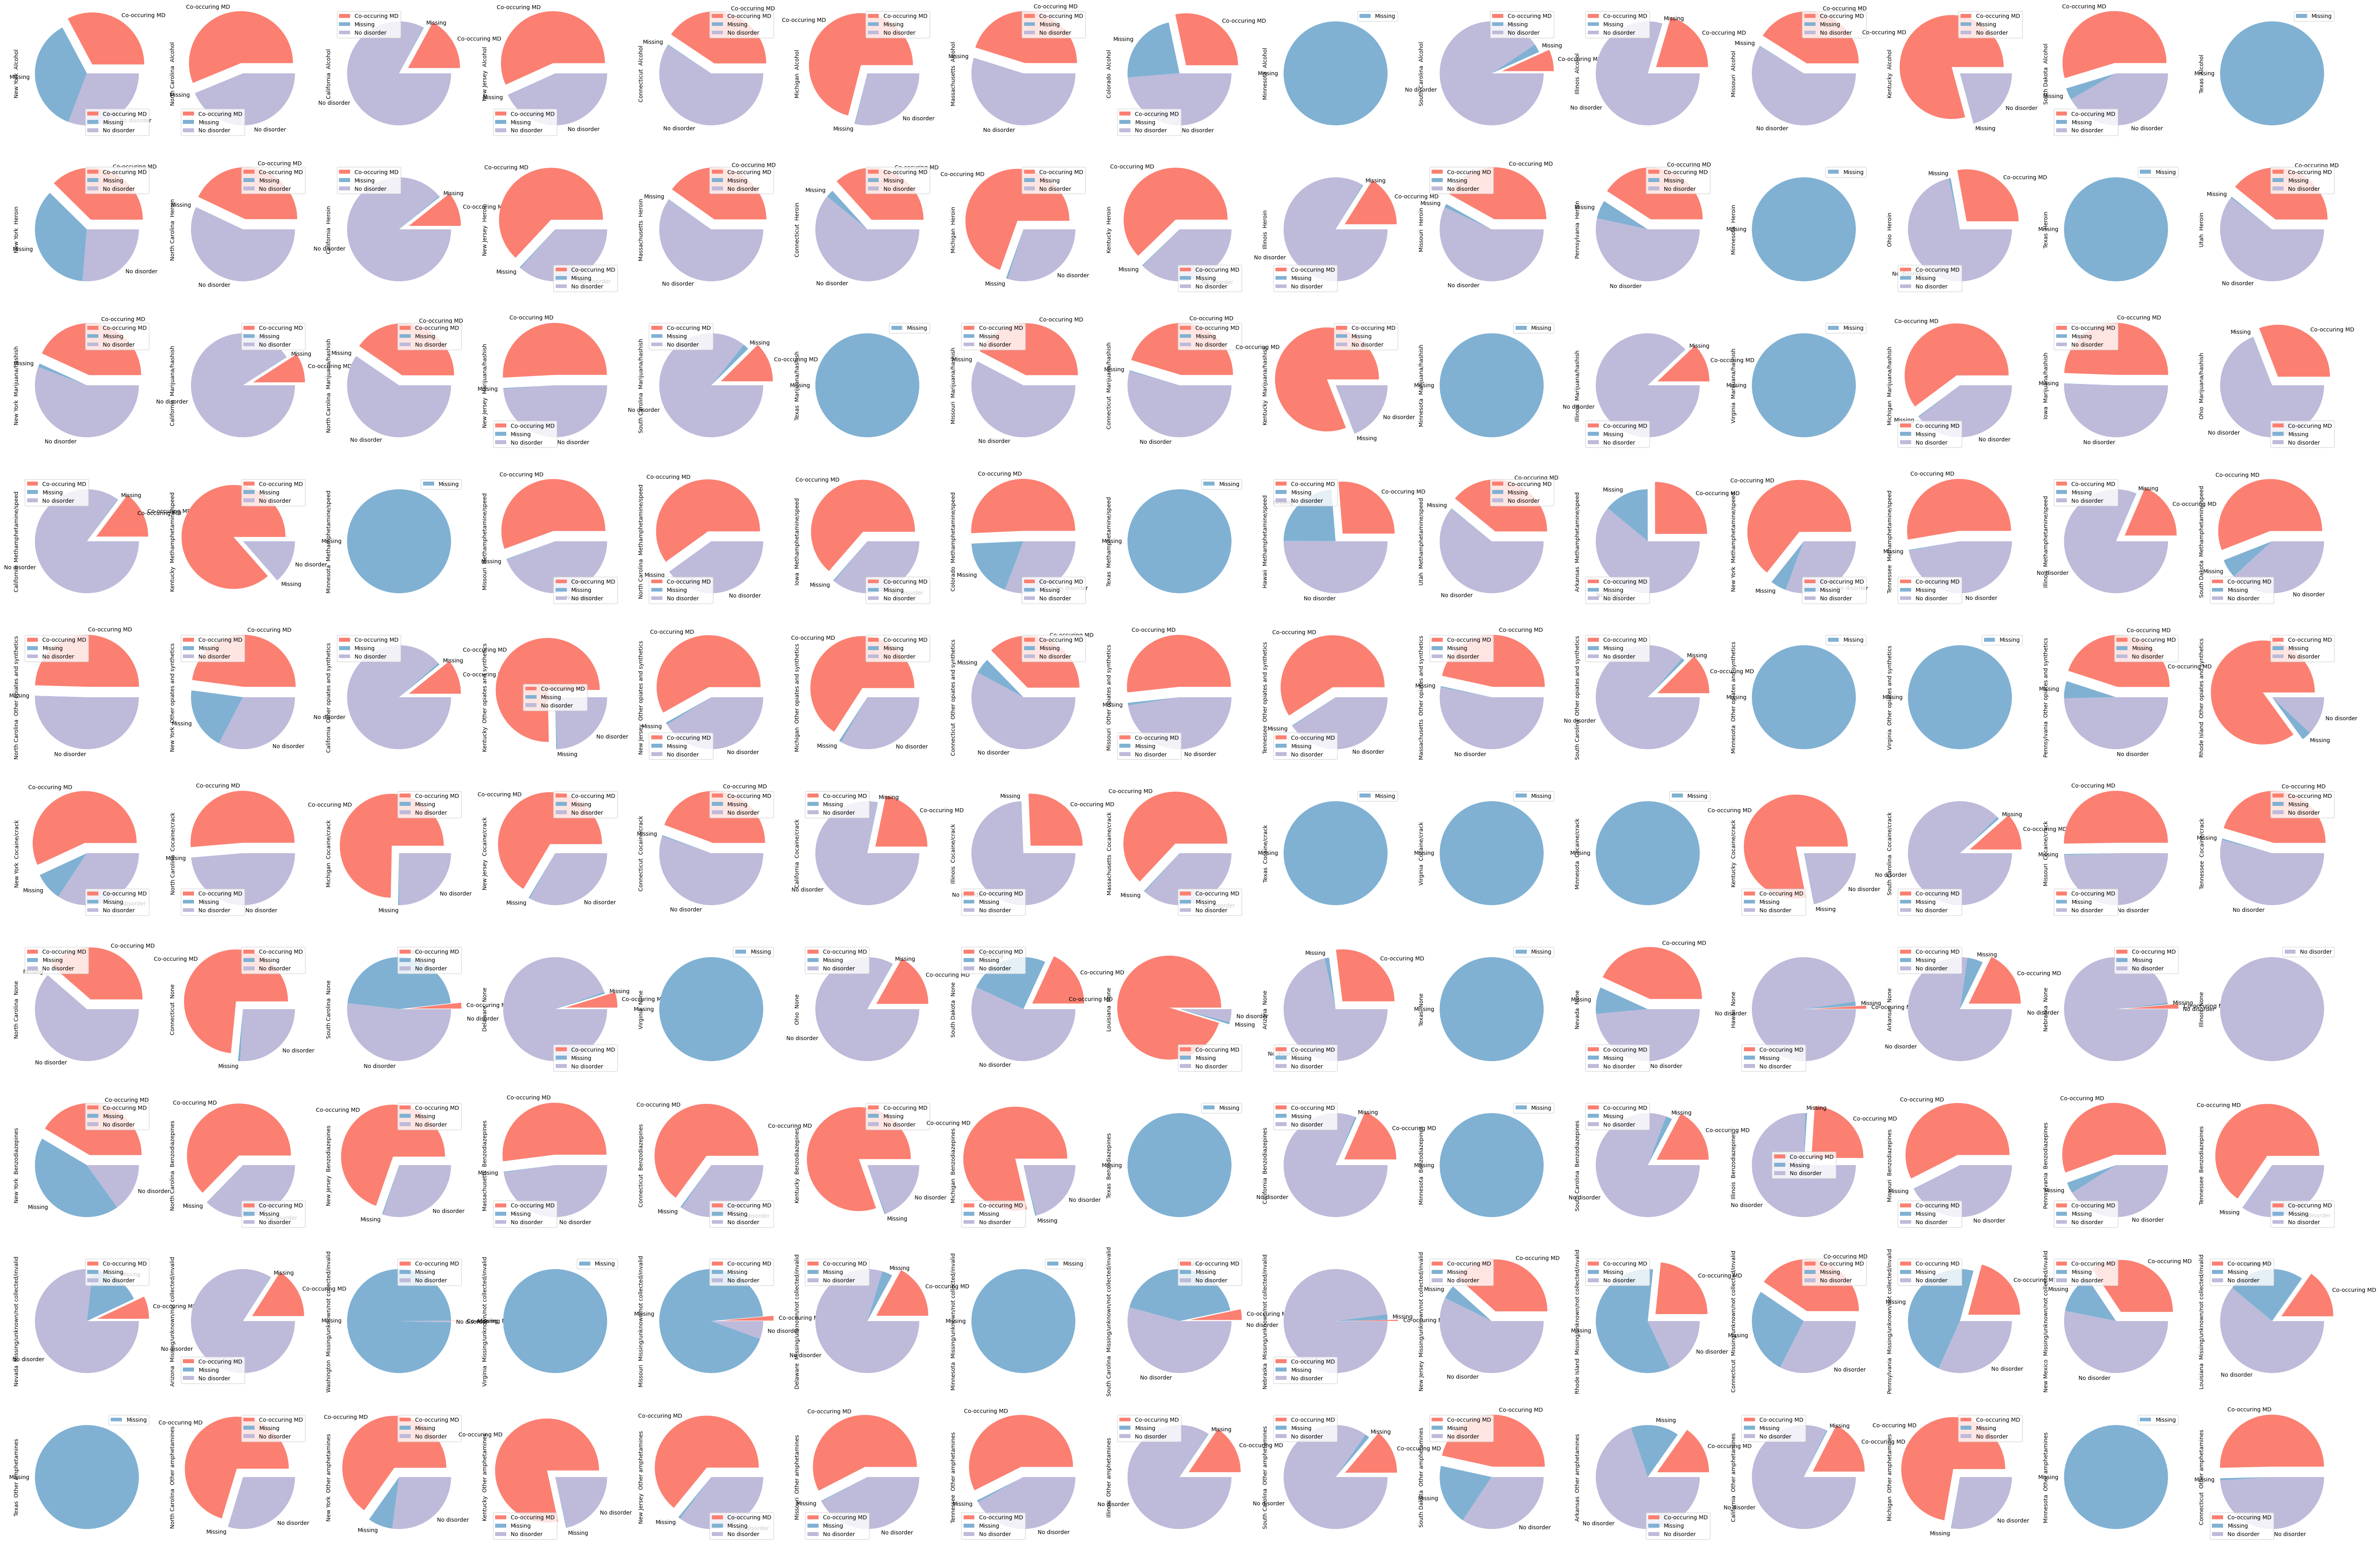

In [53]:
def cleanedf(frame,index,substance):
  
    frame = frame.reset_index().drop('level_1',axis=1)
    frame['STFIPS'] = frame['STFIPS']+"  "+substance
    return frame.set_index(index).fillna(0)
    
fig,subplots = plt.subplots(10,15,figsize=(15*5,10*5))
import seaborn as sns
colors = sns.color_palette('Set3')

colors_subset = colors[3:5]+[colors[2]]+colors[5:]

for index,substance in enumerate(df.SUB1.value_counts().sort_values(ascending=False).keys()[:10]):

    sub = df[df['SUB1']==substance]

    statewise_sub = sub.groupby('STFIPS')

    statewise_sub_psyc =  statewise_sub.apply(lambda x:pd.DataFrame(x.PSYPROB.value_counts()).T)

    statewise_sub_psyc= cleanedf(statewise_sub_psyc,'STFIPS',substance)
    
    statewise_sub_psyc['Total'] = statewise_sub_psyc.apply(lambda x:sum(x),axis=1)

    statewise_sub_psyc = statewise_sub_psyc.sort_index(axis=1)

    statewise_sub_psyc.sort_values('Total',ascending=False).iloc[:15].drop('Total',axis=1).T.plot.pie(subplots=True,colors=colors_subset,ax=subplots[index],explode=[0.2, 0, 0])

plt.show()



# Most occuring states are 


1.   Kentucky
2.   North Carolina Has ALcohol only with more MD
3.   Michigan
4.   Rhode Island'



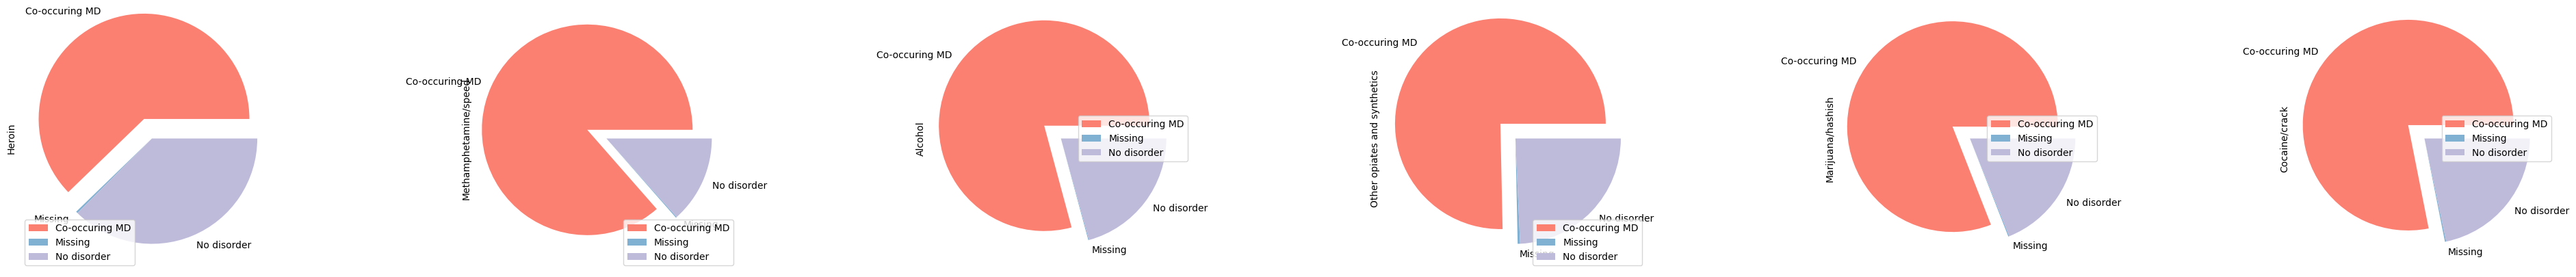

In [54]:
colors = sns.color_palette('Set3')
colors_subset = colors[3:5]+[colors[2]]+colors[5:]
state = df.groupby('STFIPS').get_group('Kentucky')
state = state.groupby('SUB1')
state_sub = state.apply(lambda x:pd.DataFrame(x.PSYPROB.value_counts()).T)
state_sub = state_sub.reset_index().drop('level_1',axis=1)
state_sub.set_index('SUB1',inplace=True)
state_sub.fillna(0,inplace=True)
state_sub['Total'] = state_sub.apply(lambda x:sum(x),axis=1)
state_sub = state_sub.sort_values('Total',ascending=False).iloc[:6]
state_sub = state_sub.sort_index(axis=1)
state_sub.drop('Total',inplace=True,axis=1)
# print(state_sub.columns)
plots = state_sub.T.plot.pie(subplots=True,figsize=(10*5,5),colors=colors_subset,explode=[0.2, 0, 0])
plt.show()

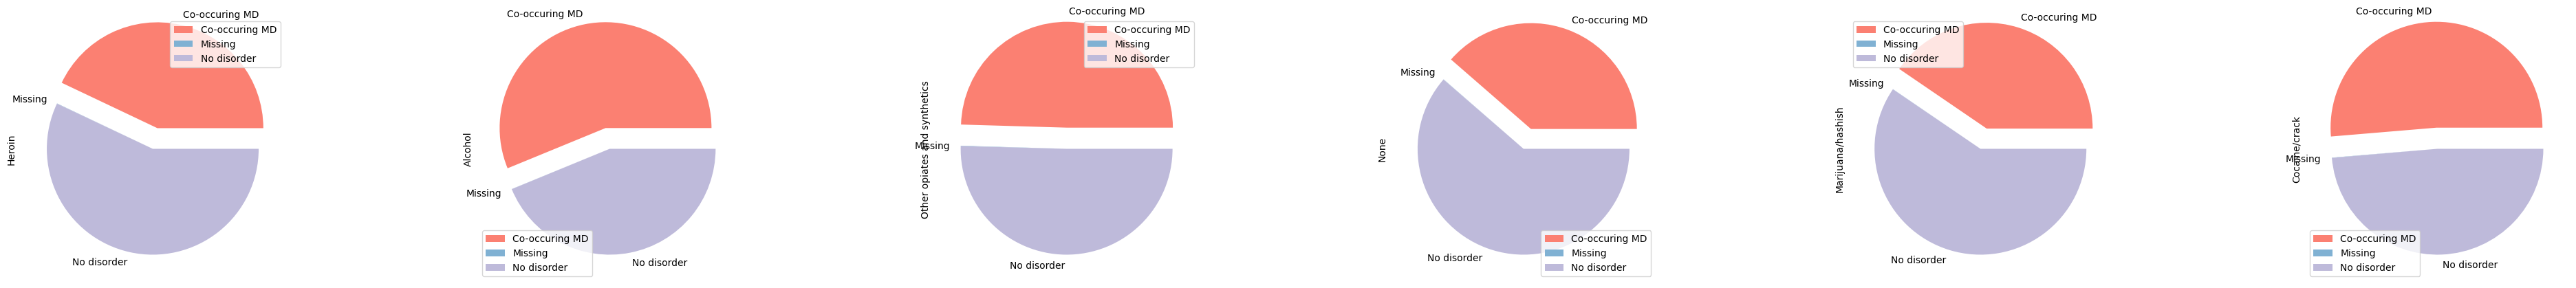

In [55]:
colors = sns.color_palette('Set3')
colors_subset = colors[3:5]+[colors[2]]+colors[5:]
state = df.groupby('STFIPS').get_group('North Carolina')
state = state.groupby('SUB1')
state_sub = state.apply(lambda x:pd.DataFrame(x.PSYPROB.value_counts()).T)
state_sub = state_sub.reset_index().drop('level_1',axis=1)
state_sub.set_index('SUB1',inplace=True)
state_sub.fillna(0,inplace=True)
state_sub['Total'] = state_sub.apply(lambda x:sum(x),axis=1)
state_sub = state_sub.sort_values('Total',ascending=False).iloc[:6]
state_sub = state_sub.sort_index(axis=1)
state_sub.drop('Total',inplace=True,axis=1)
# print(state_sub.columns)
plots = state_sub.T.plot.pie(subplots=True,figsize=(10*5,5),colors=colors_subset,explode=[0.2, 0, 0])
plt.show()

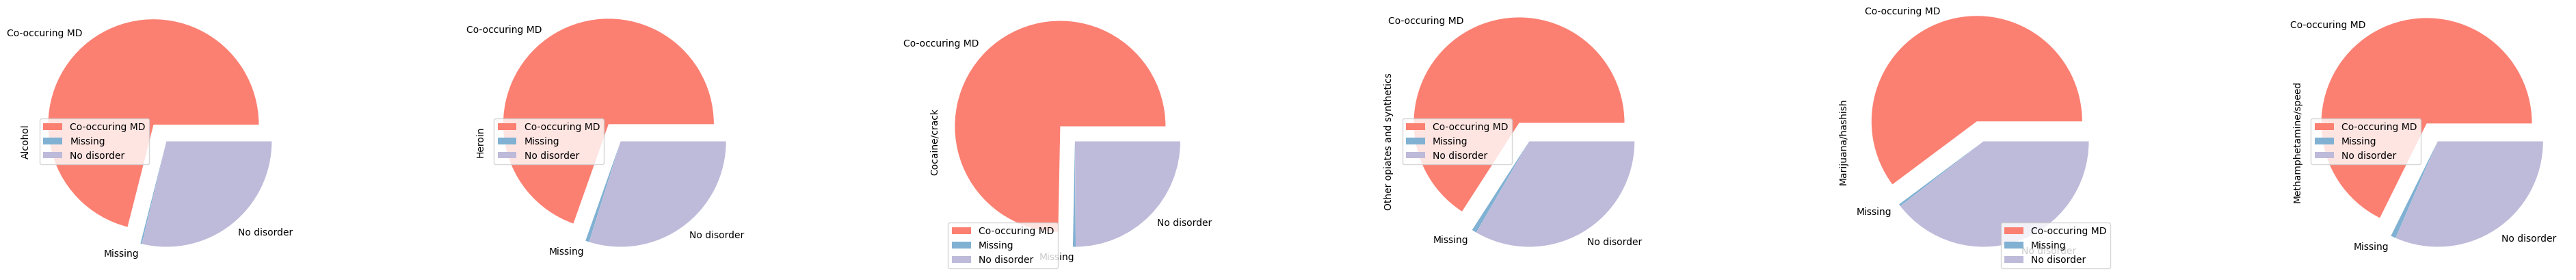

In [56]:
colors = sns.color_palette('Set3')
colors_subset = colors[3:5]+[colors[2]]+colors[5:]
state = df.groupby('STFIPS').get_group('Michigan')
state = state.groupby('SUB1')
state_sub = state.apply(lambda x:pd.DataFrame(x.PSYPROB.value_counts()).T)
state_sub = state_sub.reset_index().drop('level_1',axis=1)
state_sub.set_index('SUB1',inplace=True)
state_sub.fillna(0,inplace=True)
state_sub['Total'] = state_sub.apply(lambda x:sum(x),axis=1)
state_sub = state_sub.sort_values('Total',ascending=False).iloc[:6]
state_sub = state_sub.sort_index(axis=1)
state_sub.drop('Total',inplace=True,axis=1)
# print(state_sub.columns)
plots = state_sub.T.plot.pie(subplots=True,figsize=(10*5,5),colors=colors_subset,explode=[0.2, 0, 0])
plt.show()

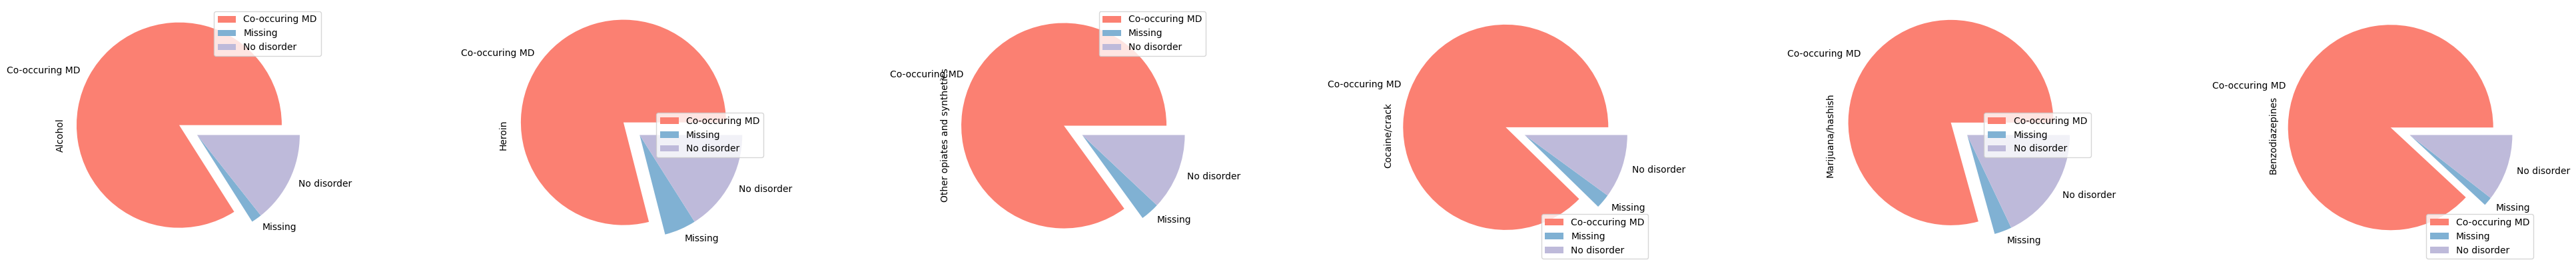

In [57]:
colors = sns.color_palette('Set3')
colors_subset = colors[3:5]+[colors[2]]+colors[5:]
state = df.groupby('STFIPS').get_group('Rhode Island')
state = state.groupby('SUB1')
state_sub = state.apply(lambda x:pd.DataFrame(x.PSYPROB.value_counts()).T)
state_sub = state_sub.reset_index().drop('level_1',axis=1)
state_sub.set_index('SUB1',inplace=True)
state_sub.fillna(0,inplace=True)
state_sub['Total'] = state_sub.apply(lambda x:sum(x),axis=1)
state_sub = state_sub.sort_values('Total',ascending=False).iloc[:6]
state_sub = state_sub.sort_index(axis=1)
state_sub.drop('Total',inplace=True,axis=1)
plots = state_sub.T.plot.pie(subplots=True,figsize=(10*5,5),colors=colors_subset,explode=[0.2, 0, 0])
plt.show()